# Práctico 2 - TSP

## Instalación de Dependencias
Instalación de dependencias requeridad para el experimento

In [1]:
# Install required packages
!pip install numpy matplotlib scipy

## Traveling Salesman Problem (TSP) Ejemplos

Este notebook utilizara matplot lib para ilustrar n ciudad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.spatial.distance import pdist, squareform

## Genera un numero random de ciudades

In [3]:
np.random.seed(42)
num_cities = 6
cities = np.random.rand(num_cities, 2) * 100  # 2D coordinates (x, y)
city_labels = [f"Ciudad {i}" for i in range(num_cities)]

## Visualización de ciudades 

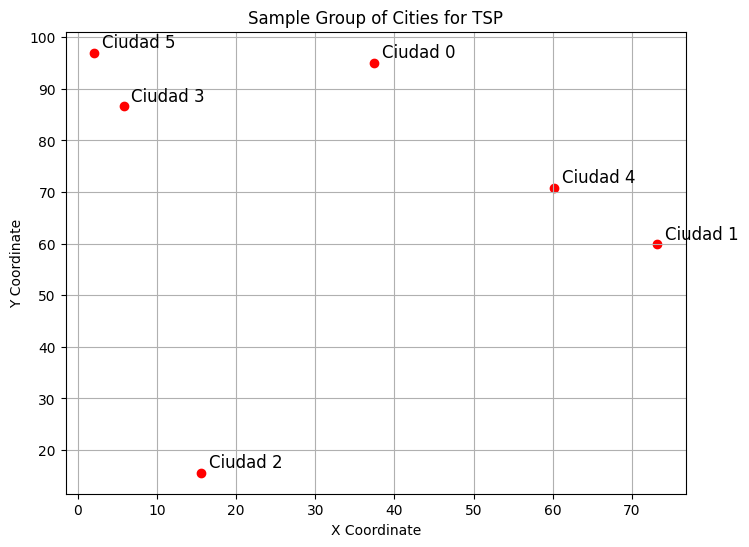

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='red')
for i, (x, y) in enumerate(cities):
    plt.text(x + 1, y + 1, city_labels[i], fontsize=12)
plt.title("Sample Group of Cities for TSP")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

## Algoritmos utilizados y helpers para su implementación

In [5]:
def route_length(route, cities):
    total = 0.0
    for i in range(len(route)):
        start = cities[route[i]]
        end = cities[route[(i+1)%len(route)]]
        total += np.linalg.norm(start - end)
    return total

In [6]:
from typing import List, Tuple, Dict

def brute_force(cities, num_cities,max_iterations: int = 10000) -> Tuple[float, List[int]]:
    routes = list(itertools.permutations(range(num_cities)))
    best_route = min(routes, key=lambda r: route_length(r, cities))
    best_length = route_length(best_route, cities)
    return best_length, best_route


In [7]:
import itertools
import random
import math
from typing import List, Tuple, Dict

class TSPHelper:
    """Helper methods for TSP algorithms.

    This class provides static methods for evaluating tour cost,
    generating neighbors, and reconstructing the optimal path.

    Methods:
        total_distance(tour, dist): Computes the cost of a tour.
        get_neighbors(tour): Generates all neighbors by pairwise swaps.
        random_neighbor(tour): Generates a neighbor by swapping two random cities.
        reconstruct_path(dp, n, last_city): Reconstructs the optimal route from DP table.
    """

    @staticmethod
    def total_distance(tour: List[int], dist: List[List[float]]) -> float:
        """Computes the total cost of a tour, returning to the start.

        Args:
            tour: List of city indices representing the tour.
            dist: 2D distance matrix.

        Returns:
            Total cost (float) of the tour including return to start.
        """
        return sum(dist[tour[i]][tour[(i + 1) % len(tour)]] for i in range(len(tour)))

    @staticmethod
    def get_neighbors(tour: List[int]) -> List[List[int]]:
        """Generates all neighbors of the tour by swapping any two cities.

        Args:
            tour: Current tour as a list of city indices.

        Returns:
            List of neighboring tours (each a list of city indices).
        """
        neighbors = []
        n = len(tour)
        for i in range(n):
            for j in range(i + 1, n):
                neighbor = tour.copy()
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                neighbors.append(neighbor)
        return neighbors

    @staticmethod
    def random_neighbor(tour: List[int]) -> List[int]:
        """Generates a neighbor by randomly swapping two cities.

        Args:
            tour: Current tour as a list of city indices.

        Returns:
            Neighboring tour after a random swap.
        """
        a, b = random.sample(range(len(tour)), 2)
        neighbor = tour.copy()
        neighbor[a], neighbor[b] = neighbor[b], neighbor[a]
        return neighbor

    @staticmethod
    def reconstruct_path(dp: Dict[Tuple[int, int], Tuple[float, int]], n: int, last_city: int) -> List[int]:
        """Reconstructs the optimal route from the Held-Karp DP table.

        Args:
            dp: DP table with (subset, last_city) as key and (cost, previous_city) as value.
            n: Number of cities.
            last_city: Last city visited before return to start.

        Returns:
            Optimal tour as a list of city indices (starting and ending at 0).
        """
        path = [0]
        bits = (1 << n) - 2  # All cities except start
        city = last_city
        for _ in range(n - 1):
            path.append(city)
            bits, prev_city = bits & ~(1 << city), dp[(bits, city)][1]
            city = prev_city
        path = path[::-1]
        return path

In [8]:
from scipy.spatial.distance import pdist, squareform

def hill_climbing(cities, num_cities):
    dist = squareform(pdist(cities))
    return hill_climbing_int(dist)

def simulated_annealing(cities, num_cities):
    dist = squareform(pdist(cities))
    return simulated_annealing_int(dist)

def hill_climbing_int(dist: List[List[float]], max_iterations: int = 10_000) -> Tuple[float, List[int]]:
    """Solves the TSP using Hill Climbing local search.

    Starts from a random tour and iteratively moves to the best neighbor
    found by swapping any two cities. Terminates when no improvement is possible.

    Args:
        dist: 2D matrix (n x n) of costs between cities.
        max_iterations: Maximum number of iterations.

    Returns:
        Tuple: (cost of best tour found, tour as list of city indices)
    """
    n = len(dist)
    current_tour = list(range(n))
    random.shuffle(current_tour)
    current_cost = TSPHelper.total_distance(current_tour, dist)

    for _ in range(max_iterations):
        neighbors = TSPHelper.get_neighbors(current_tour)
        neighbor_costs = [TSPHelper.total_distance(neigh, dist) for neigh in neighbors]
        min_cost = min(neighbor_costs)
        if min_cost < current_cost:
            idx = neighbor_costs.index(min_cost)
            current_tour = neighbors[idx]
            current_cost = min_cost
        else:
            break  # Local minimum reached

    return current_cost, current_tour

def simulated_annealing_int(dist: List[List[float]], initial_temp: float = 1000.0,
                        cooling_rate: float = 0.995, max_iterations: int = 10_000) -> Tuple[float, List[int]]:
    """Solves the TSP using Simulated Annealing.

    Starts from a random tour and randomly samples neighbors (by swapping two cities).
    Moves to worse solutions with a probability that decreases with temperature.
    Can escape local minima to find better solutions.

    Args:
        dist: 2D matrix (n x n) of costs between cities.
        initial_temp: Starting temperature for annealing.
        cooling_rate: Rate at which the temperature decreases.
        max_iterations: Maximum number of iterations.

    Returns:
        Tuple: (cost of best tour found, tour as list of city indices)
    """
    n = len(dist)
    current_tour = list(range(n))
    random.shuffle(current_tour)
    current_cost = TSPHelper.total_distance(current_tour, dist)
    best_tour = current_tour[:]
    best_cost = current_cost
    temp = initial_temp

    for _ in range(max_iterations):
        neighbor = TSPHelper.random_neighbor(current_tour)
        neighbor_cost = TSPHelper.total_distance(neighbor, dist)
        delta = neighbor_cost - current_cost
        # Accept neighbor if it improves cost or probabilistically if not
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_tour = neighbor
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best_tour = current_tour[:]
                best_cost = current_cost
        temp *= cooling_rate
        if temp < 1e-8:
            break

    return best_cost, best_tour


## Helpers para ejecución de pruebas y graficos

In [9]:
def plot_complexity(city_counts, solve_times, algoritm):
    plt.figure(figsize=(8, 6))
    for i, n in enumerate(city_counts):
        plt.scatter(n, solve_times[i], color='blue')
        plt.text(n, solve_times[i], f"{solve_times[i]:.4g}s", fontsize=9, ha='left', va='bottom')
    plt.plot(city_counts, solve_times, marker='o', color='blue')
    plt.title(f"{algoritm.__name__} TSP Time Complexity vs Number of Cities (3 to {len(city_counts)+2})")
    plt.xlabel("Number of Cities")
    plt.ylabel("Computation Time (seconds)")
    plt.grid(True)
    plt.show()

In [10]:
# Defensive mechanism to avoid log(0) underflow for very small times
def plot_log_complexity(city_counts, solve_times,algoritm):
    log_times = [t if t > 0 else 1e-6 for t in solve_times]
    plt.figure(figsize=(8, 6))
    plt.plot(city_counts, log_times, marker='o', color='purple')
    for i, n in enumerate(city_counts):
        plt.text(n, log_times[i], f"{solve_times[i]:.4g}s", fontsize=9, ha='left', va='bottom')
    plt.yscale('log')
    plt.title(f"{algoritm.__name__} TSP Computation Time (Log Scale) vs Number of Cities (3 to {len(city_counts)+2})")
    plt.xlabel("Number of Cities")
    plt.ylabel("Computation Time (seconds, log scale)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

In [11]:
import time

def run_n_cities(algorithm, max_cities=6, show_plots=True):
    np.random.seed(42)
    initial_cities = np.random.rand(3, 2) * 100
    cities = initial_cities.copy()
    city_labels = [f"City {i}" for i in range(3)]
    solve_times = []
    best_costs = []
    city_counts = list(range(3, max_cities + 1))
    result_rows = []  # (n, route_str, best_length_str, elapsed_str)

    algo_name = getattr(algorithm, "__name__", "algorithm")

    # Sólo preparamos objetos de figura/axes si realmente vamos a plotear
    if show_plots:
        fig = None
        axes = None
        slot_idx = 0
        slots_in_fig = 0

    for i, n in enumerate(city_counts):
        if n > 3:
            # Add one new city
            new_city = np.random.rand(1, 2) * 100
            cities = np.vstack([cities, new_city])
            city_labels.append(f"City {n-1}")

        start_time = time.time()
        best_length, best_route = algorithm(cities, n)
        elapsed = time.time() - start_time

        solve_times.append(elapsed)
        best_costs.append(best_length)

        # progreso corto por problema
        print(f"[{i+1}/{len(city_counts)}] ciudades={n} | tiempo={elapsed:.4f}s | costo={best_length:.2f}")

        # ----------- PLOTEO (opcional) -----------
        if show_plots:
            # subplots de a 3
            if slot_idx == 0:
                remaining = min(3, len(city_counts) - i)
                fig, axes = plt.subplots(1, remaining, figsize=(6 * remaining, 5))
                if remaining == 1:
                    axes = [axes]  # normaliza a lista
                slots_in_fig = remaining

            ax = axes[slot_idx]
            slot_idx += 1

            # puntos y labels
            ax.scatter(cities[:, 0], cities[:, 1])
            for j, (x, y) in enumerate(cities):
                ax.text(x + 1, y + 1, city_labels[j], fontsize=9)

            # ruta
            route_cities = np.array([cities[k] for k in best_route] + [cities[best_route[0]]])
            ax.plot(route_cities[:, 0], route_cities[:, 1], marker='o')

            ax.set_title(f"[{algo_name}] TSP {n} | Costo {best_length:.2f}\nTiempo {elapsed:.4f}s")
            ax.set_xlabel("X")
            ax.set_ylabel("Y")
            ax.grid(True)

            # si llenamos la fila (3) o es el último, mostrar y resetear
            if slot_idx == slots_in_fig or i == len(city_counts) - 1:
                plt.tight_layout()
                plt.show()
                slot_idx = 0  # listo para la próxima figura
        # ----------- FIN PLOTEO -----------

        # guardar para la tabla final
        route_str = "->".join(map(str, best_route))
        result_rows.append((n, route_str, f"{best_length:.2f}", f"{elapsed:.4f}"))

    # --- tabla final: n | ruta | largo | tiempo(s) ---
    headers = ["n", "ruta", "largo", "tiempo(s)"]
    col_widths = [
        max(len(str(h)), *(len(str(r[c])) for r in result_rows))
        for c, h in enumerate(headers)
    ]

    def fmt_row(row):
        return " | ".join(str(val).ljust(col_widths[c]) for c, val in enumerate(row))

    sep = "-+-".join("-" * w for w in col_widths)

    print("\n" + fmt_row(headers))
    print(sep)
    for row in result_rows:
        print(fmt_row(row))

    # gráficos de complejidad sólo si se pidió plotear
    if show_plots:
        plot_complexity(city_counts, solve_times, algorithm)        # agrega título dentro con algo_name si querés
        plot_log_complexity(city_counts, solve_times, algorithm)

    return city_counts, solve_times, best_costs

In [12]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # para ticks enteros

def plot_algorithms_times_costs(algorithms, max_cities, start_at=3):
    """
    algorithms: lista de funciones [alg1, alg2, ...]
    max_cities: se pasa directo a run_n_cities(...)
    run_n_cities: callable (algorithm, max_cities, show_plots=False) -> (city_counts, solve_times, best_costs)
    start_at: mínimo de ciudades a graficar (por defecto 3)
    """
    series = []  # [(label, x, times, costs), ...]

    for alg in algorithms:
        city_counts, solve_times, best_costs = run_n_cities(alg, max_cities, show_plots=False)

        # filtrar desde start_at
        idxs = [i for i, n in enumerate(city_counts) if n >= start_at]
        x = [city_counts[i] for i in idxs]
        t = [int(solve_times[i]) if float(solve_times[i]).is_integer() else float(solve_times[i]) for i in idxs]
        c = [int(best_costs[i]) if float(best_costs[i]).is_integer() else float(best_costs[i]) for i in idxs]

        label = getattr(alg, "__name__", str(alg))
        series.append((label, x, t, c))

    # --- graficar ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax_time, ax_cost = axes

    for label, x, t, c in series:
        ax_time.plot(x, t, marker='o', label=label)
        ax_cost.plot(x, c, marker='o', label=label)

    # subplot tiempos
    ax_time.set_title("Tiempo (log) vs. Nº de ciudades")
    ax_time.set_xlabel("Ciudades (n)")
    ax_time.set_ylabel("Tiempo (s)")
    ax_time.set_yscale("log")
    ax_time.xaxis.set_major_locator(MaxNLocator(integer=True))  # ticks enteros
    ax_time.grid(True)
    ax_time.legend()

    # subplot costos
    ax_cost.set_title("Costo vs. Nº de ciudades")
    ax_cost.set_xlabel("Ciudades (n)")
    ax_cost.set_ylabel("Costo de la ruta")
    ax_cost.xaxis.set_major_locator(MaxNLocator(integer=True))  # ticks enteros
    ax_cost.grid(True)
    ax_cost.legend()

    plt.tight_layout()
    plt.show()
    return series



## Algoritmo de Brute-Force  para un número pequeño de ciudades

In [13]:
best_length, best_route = brute_force(cities, num_cities)
print("Best route:", best_route)
print("Best route length: {:.2f}".format(best_length))

Best route: (0, 4, 1, 2, 3, 5)
Best route length: 241.07


### Representación grafica de Brute-Force

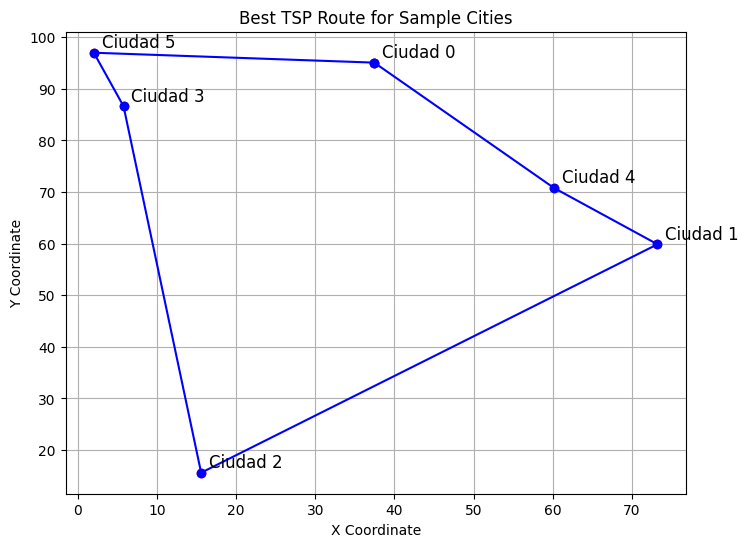

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='red')
for i, (x, y) in enumerate(cities):
    plt.text(x + 1, y + 1, city_labels[i], fontsize=12)

# Draw the route
route_cities = np.array([cities[i] for i in best_route] + [cities[best_route[0]]])
plt.plot(route_cities[:, 0], route_cities[:, 1], 'b-o')

plt.title("Best TSP Route for Sample Cities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

### Ruta random de TSP para comparación

Random route: [4 2 0 5 1 3]
Random route length: 398.09


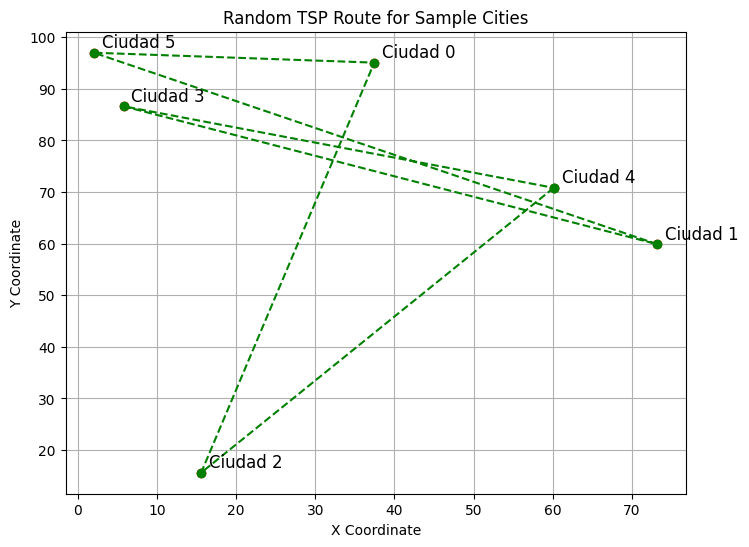

In [15]:
random_route = np.random.permutation(num_cities)
random_length = route_length(random_route, cities)

print("Random route:", random_route)
print("Random route length: {:.2f}".format(random_length))

plt.figure(figsize=(8, 6))
plt.scatter(cities[:, 0], cities[:, 1], c='red')
for i, (x, y) in enumerate(cities):
    plt.text(x + 1, y + 1, city_labels[i], fontsize=12)

route_cities = np.array([cities[i] for i in random_route] + [cities[random_route[0]]])
plt.plot(route_cities[:, 0], route_cities[:, 1], 'g--o')
plt.title("Random TSP Route for Sample Cities")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

## Solución y Visualización del Algoritmo TSP para un Número Incremental de Ciudades

Esta sección calcula la solución del algoritmo TSP para entre 3 y n ciudades, agregando una ciudad a la vez al conjunto existente, y visualiza la ruta óptima junto con el tiempo y el costo para cada caso.

[1/6] ciudades=3 | tiempo=0.0004s | costo=205.24
[2/6] ciudades=4 | tiempo=0.0013s | costo=227.26
[3/6] ciudades=5 | tiempo=0.0053s | costo=227.35


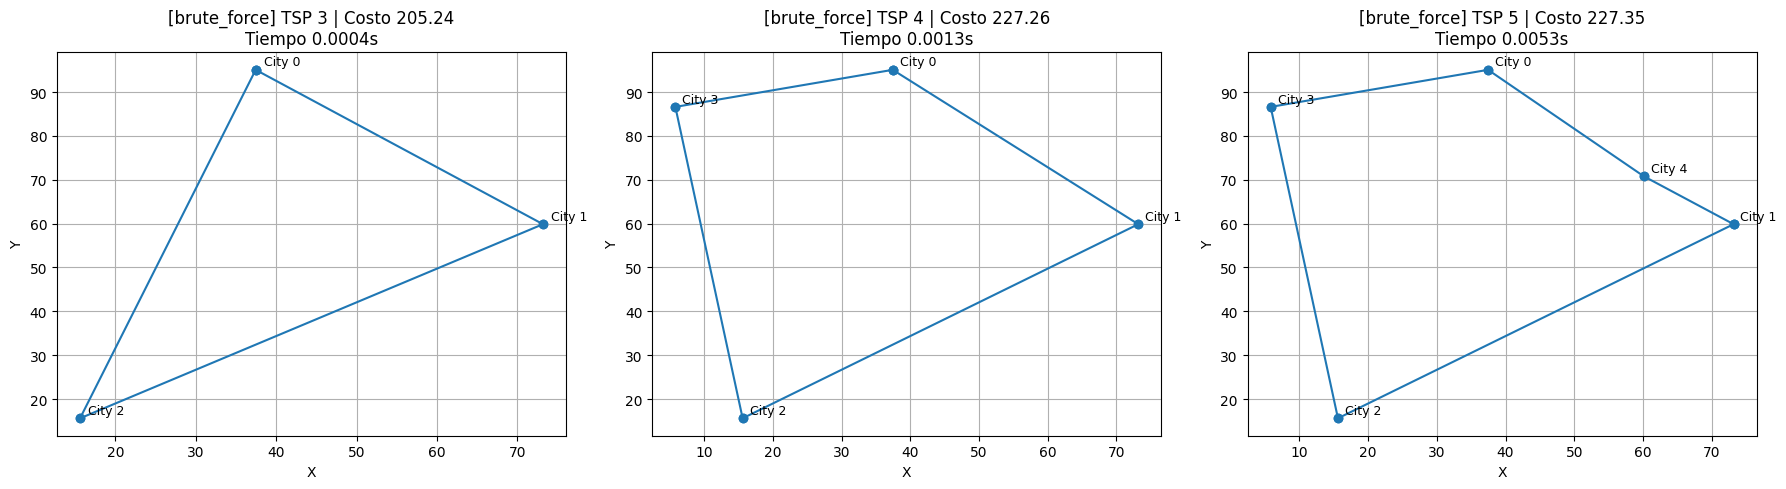

[4/6] ciudades=6 | tiempo=0.0416s | costo=241.07
[5/6] ciudades=7 | tiempo=0.3275s | costo=276.22
[6/6] ciudades=8 | tiempo=2.9347s | costo=277.23


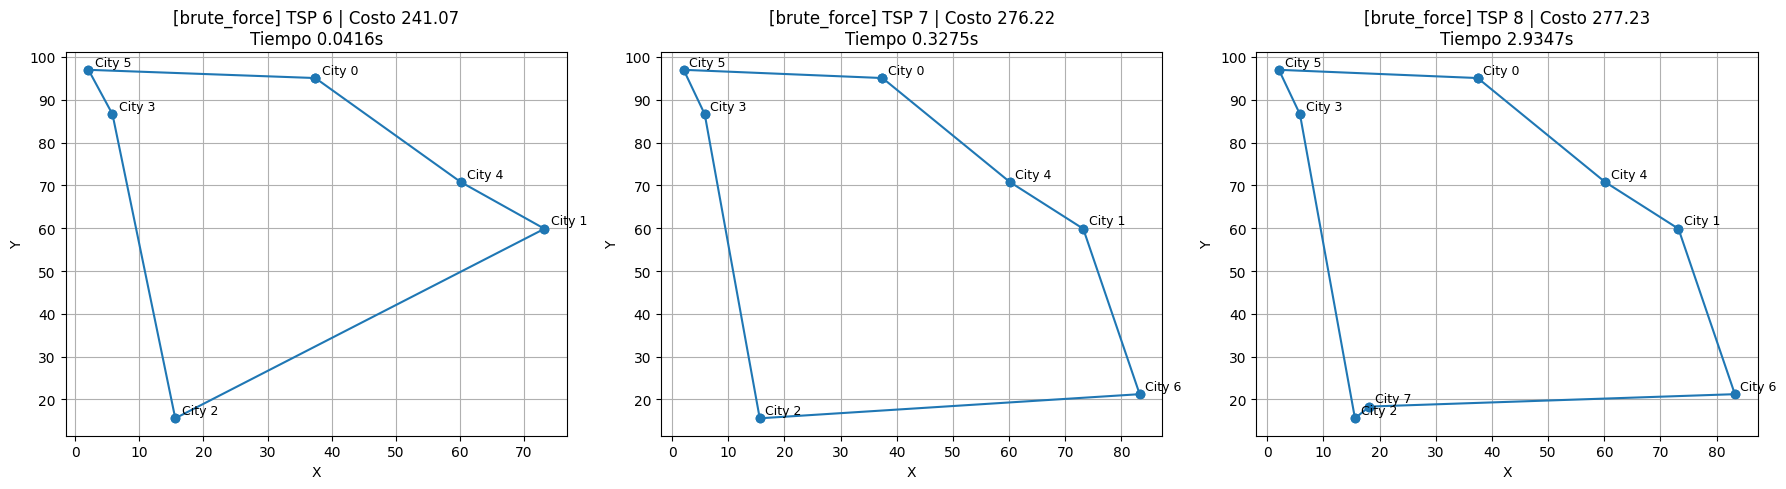


n | ruta                   | largo  | tiempo(s)
--+------------------------+--------+----------
3 | 0->1->2                | 205.24 | 0.0004   
4 | 0->1->2->3             | 227.26 | 0.0013   
5 | 1->4->0->3->2          | 227.35 | 0.0053   
6 | 0->4->1->2->3->5       | 241.07 | 0.0416   
7 | 0->4->1->6->2->3->5    | 276.22 | 0.3275   
8 | 0->5->3->2->7->6->1->4 | 277.23 | 2.9347   


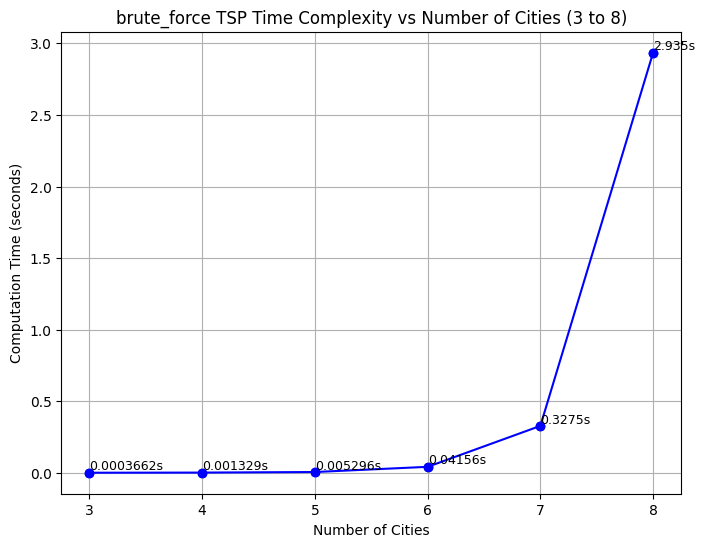

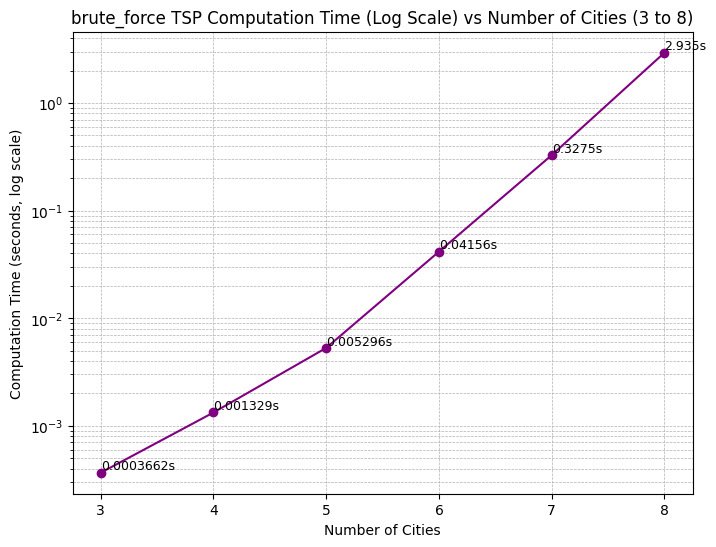

In [16]:
np.random.seed(42)

import time
algorithm=brute_force
max_cities = 8   
city_counts, solve_times,_ = run_n_cities(algorithm, max_cities)


### HeldKarp
Implementación de HeldKarp

In [17]:
from scipy.spatial.distance import pdist, squareform

def held_karp(cities, num_cities):
    dist = squareform(pdist(cities))
    return held_karp_dist(dist)

def held_karp_dist(dist: List[List[float]]) -> Tuple[float, List[int]]:
    """Solves the TSP using Held-Karp Dynamic Programming algorithm.

    This is an exact algorithm with O(n^2 * 2^n) time and space complexity.
    Suitable only for small n (n <= 20).

    Args:
        dist: 2D matrix (n x n) of costs between cities.

    Returns:
        Tuple: (minimum tour cost, tour as list of city indices)
    """
    n = len(dist)
    dp = {}

    # Base case: starting from city 0 to k (only city k visited)
    for k in range(1, n):
        dp[(1 << k, k)] = (dist[0][k], 0)

    # Build up solutions for subsets of increasing size
    for subset_size in range(2, n):
        for subset in itertools.combinations(range(1, n), subset_size):
            bits = sum(1 << bit for bit in subset)
            for k in subset:
                prev_bits = bits & ~(1 << k)
                # Find best previous city to reach k
                min_cost, prev_city = min(
                    ((dp[(prev_bits, m)][0] + dist[m][k], m)
                     for m in subset if m != k),
                    default=(float('inf'), -1)
                )
                dp[(bits, k)] = (min_cost, prev_city)

    # Complete the tour by returning to start
    bits = (1 << n) - 2  # All cities except 0
    min_cost, last_city = min(
        ((dp[(bits, k)][0] + dist[k][0], k)
         for k in range(1, n)),
        default=(float('inf'), -1)
    )

    # Reconstruct path using helper
    path = TSPHelper.reconstruct_path(dp, n, last_city)
    return min_cost, path


[1/13] ciudades=3 | tiempo=0.0008s | costo=205.24
[2/13] ciudades=4 | tiempo=0.0003s | costo=227.26
[3/13] ciudades=5 | tiempo=0.0003s | costo=227.35


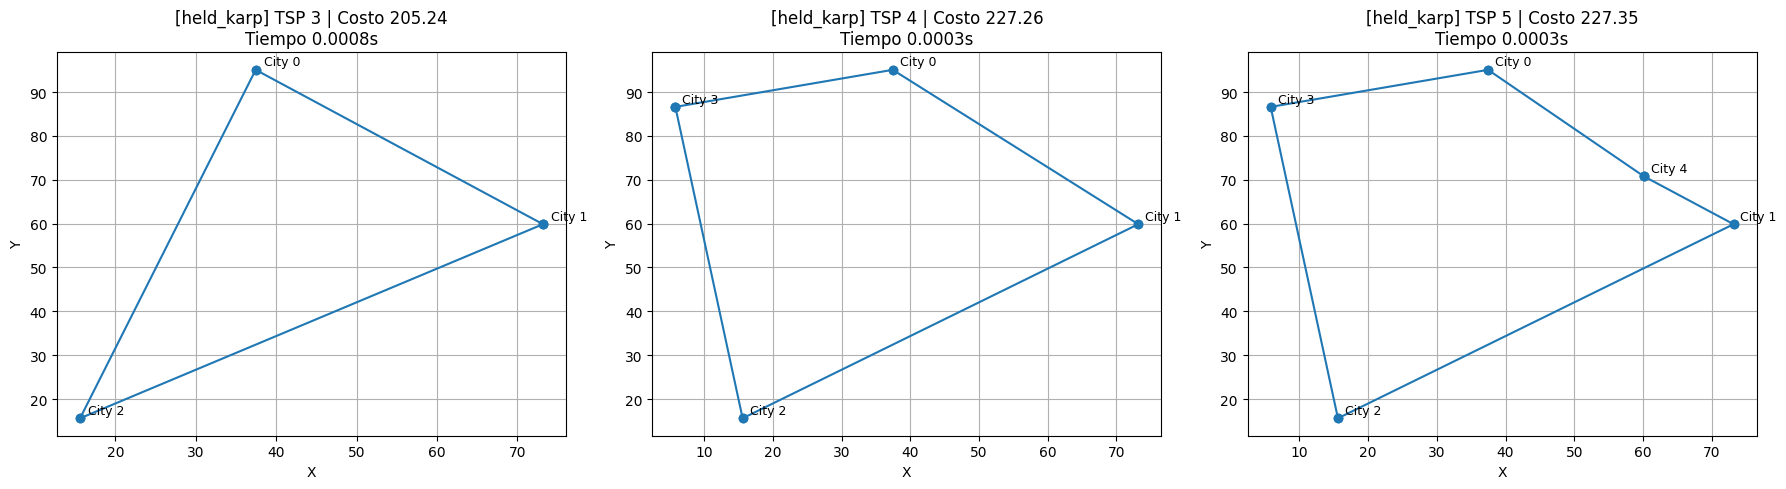

[4/13] ciudades=6 | tiempo=0.0006s | costo=241.07
[5/13] ciudades=7 | tiempo=0.0011s | costo=276.22
[6/13] ciudades=8 | tiempo=0.0030s | costo=277.23


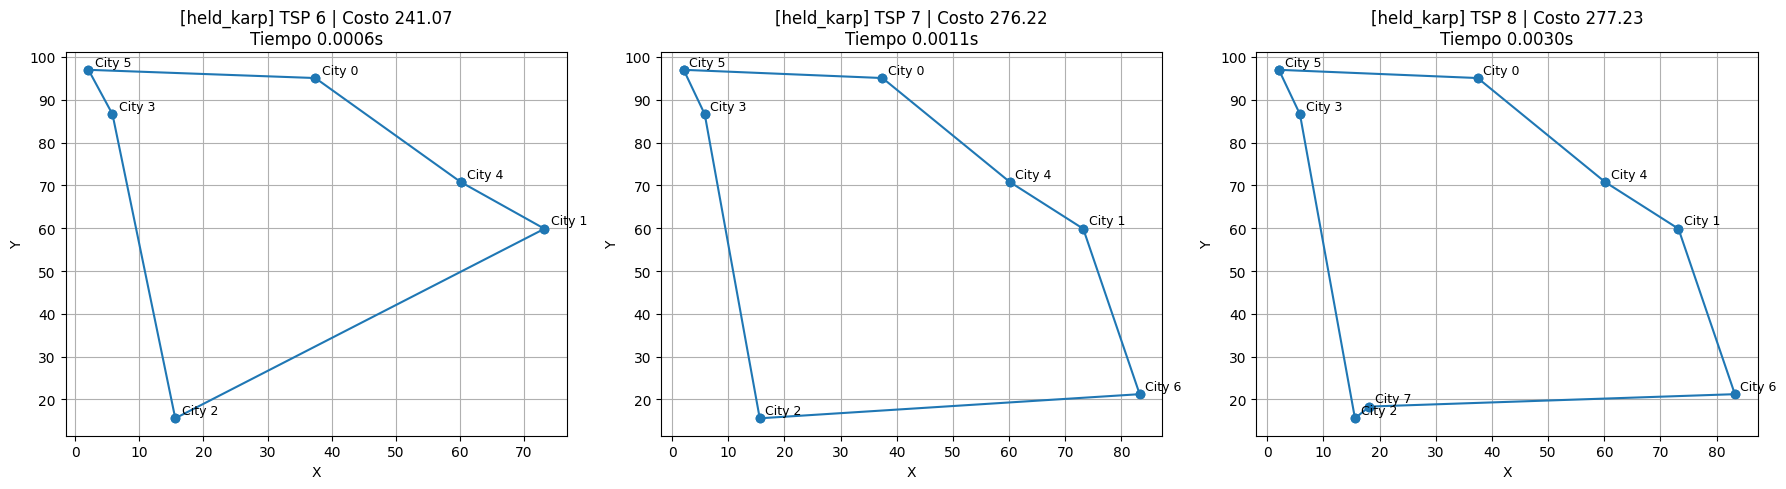

[7/13] ciudades=9 | tiempo=0.0068s | costo=286.65
[8/13] ciudades=10 | tiempo=0.0170s | costo=290.31
[9/13] ciudades=11 | tiempo=0.0448s | costo=296.25


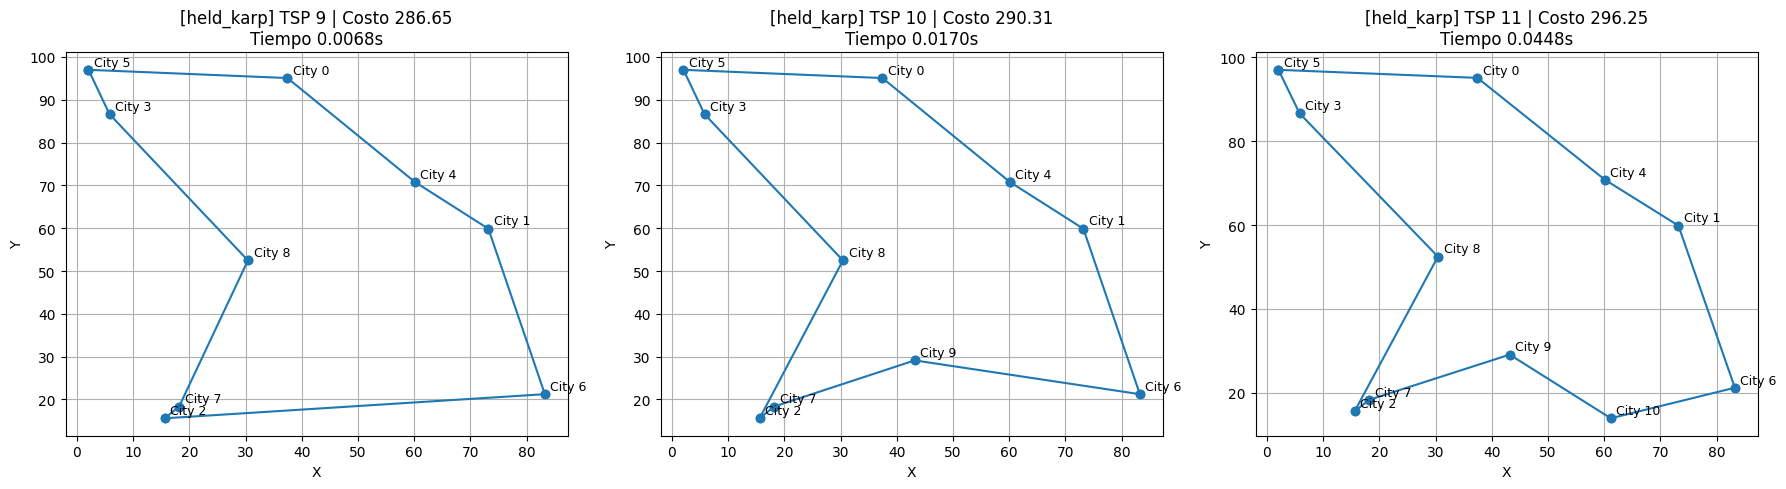

[10/13] ciudades=12 | tiempo=0.1017s | costo=297.25
[11/13] ciudades=13 | tiempo=0.2221s | costo=298.93
[12/13] ciudades=14 | tiempo=0.7947s | costo=305.29


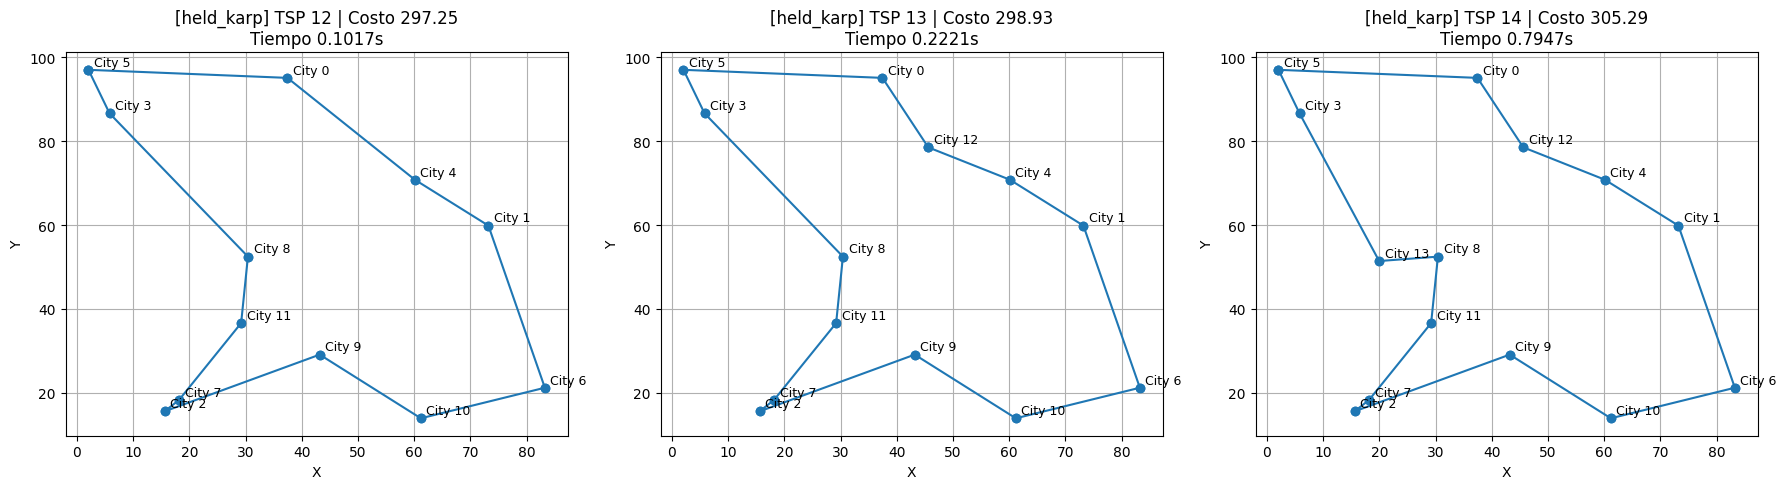

[13/13] ciudades=15 | tiempo=1.2664s | costo=320.53


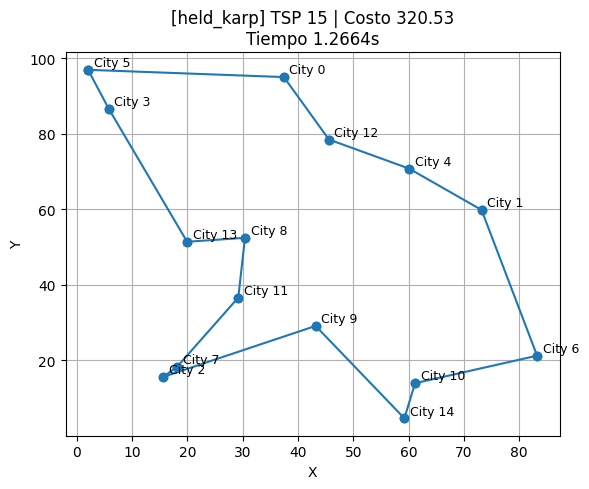


n  | ruta                                             | largo  | tiempo(s)
---+--------------------------------------------------+--------+----------
3  | 1->2->0                                          | 205.24 | 0.0008   
4  | 3->2->1->0                                       | 227.26 | 0.0003   
5  | 4->1->2->3->0                                    | 227.35 | 0.0003   
6  | 4->1->2->3->5->0                                 | 241.07 | 0.0006   
7  | 5->3->2->6->1->4->0                              | 276.22 | 0.0011   
8  | 5->3->2->7->6->1->4->0                           | 277.23 | 0.0030   
9  | 5->3->8->7->2->6->1->4->0                        | 286.65 | 0.0068   
10 | 4->1->6->9->7->2->8->3->5->0                     | 290.31 | 0.0170   
11 | 5->3->8->2->7->9->10->6->1->4->0                 | 296.25 | 0.0448   
12 | 5->3->8->11->7->2->9->10->6->1->4->0             | 297.25 | 0.1017   
13 | 12->4->1->6->10->9->2->7->11->8->3->5->0         | 298.93 | 0.2221   
14 | 5->3->13->8->11->7-

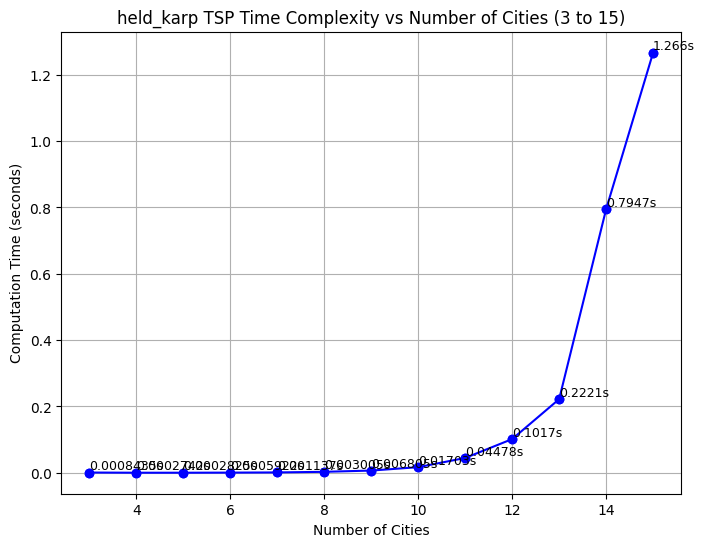

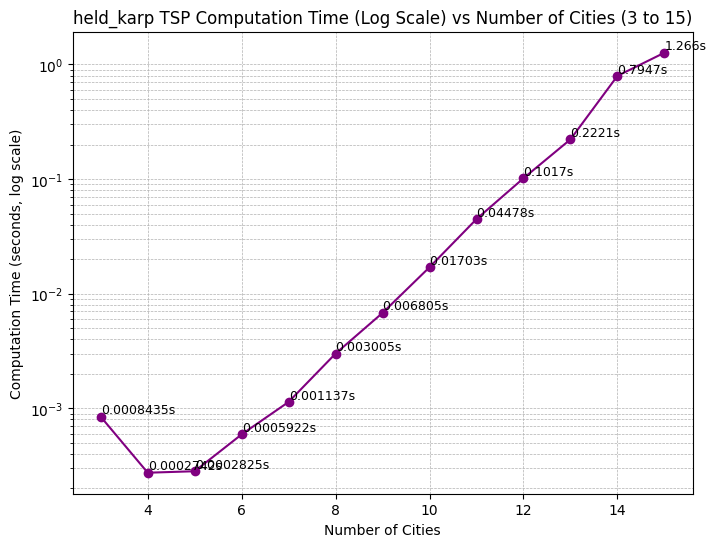

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [0.0008435249328613281, 0.0002741813659667969, 0.00028252601623535156, 0.0005922317504882812, 0.0011372566223144531, 0.0030050277709960938, 0.0068051815032958984, 0.017032623291015625, 0.0447845458984375, 0.10171818733215332, 0.2221221923828125, 0.7947278022766113, 1.2664353847503662] [np.float64(205.23579819680498), np.float64(227.25986949326284), np.float64(227.34551867849092), np.float64(241.06807549059883), np.float64(276.21833744551475), np.float64(277.23241951682456), np.float64(286.6472235549413), np.float64(290.3067737777875), np.float64(296.25323192212375), np.float64(297.2509182121361), np.float64(298.93200692682495), np.float64(305.2866704174466), np.float64(320.5256656696074)]


In [18]:
np.random.seed(42)

import time
algorithm=held_karp
max_cities = 15  
city_counts, solve_times, best_costs = run_n_cities(algorithm, max_cities, show_plots=True)
print(city_counts, solve_times, best_costs)



## Tarea 1  - BnB adaptado para el Problema de TSP
Parte 1) Adapte los siguientes metodos de bound.
- `lb_cost(D,path,start)`


Parte 2) Realice los metodos de busqueda para BFS y DFS.
Compare los algoritmos en terminos de eficiencia, ambos llegan hasta el optimo?


Determine cual es el maximo de cantidad de ciudad que se puede utilizar cada combinación sin que este algoritmo se dispare exponencial. Realice comentarios sobre la calidad de la solución obtenida. 


https://www.geeksforgeeks.org/dsa/traveling-salesman-problem-using-branch-and-bound-2/ Guía 



### Utils

In [19]:
from typing import List, Tuple, Callable, Optional
from collections import deque
import heapq
import math

Path = List[int]
BoundFn = Callable[[List[List[float]], Path, int], float]

def path_cost(D: List[List[float]], path: Path) -> float:
    return sum(D[path[i]][path[i+1]] for i in range(len(path)-1)) if len(path) > 1 else 0.0

def complete_cost(D: List[List[float]], path: Path, start: int) -> float:
    return path_cost(D, path) + D[path[-1]][start]

def unvisited(D: List[List[float]], path: Path) -> List[int]:
    used = set(path)
    return [i for i in range(len(D)) if i not in used]

def children(D: List[List[float]], path: Path) -> List[Path]:
    return [path + [j] for j in unvisited(D, path)]

### Cotas

In [20]:


def lb_trivial(D: List[List[float]], path: Path, start: int) -> float:
    # solo costo parcial; si es hoja, añade retorno
    cost = path_cost(D, path)
    if len(path) == len(D):
        cost += D[path[-1]][start]
    return cost

def lb_cost(D: List[List[float]], path: Path, start: int) -> float:
    """
    UP = costo(u,v) + costo reducido + costo reducido' 
    """
    n = len(D)
    cost = path_cost(D, path)
    unv = unvisited(D, path)

    # costo reducido
    red_cost = 0.0
    for u in unv:
        row = [D[u][v] for v in unv if v != u]
        min_row = min(row) if row else 0.0
        red_cost += min_row

        col = [D[v][u] for v in unv if v != u]
        min_col = min(col) if col else 0.0
        red_cost += min_col

    red_cost /= 2.0

    # costo reducido' (desde último nodo en path)
    last = path[-1]
    row = [D[last][v] for v in unv]
    min_row = min(row) if row else 0.0
    red_cost += min_row

    # costo reducido'' (hacia primer nodo en path)
    first = path[0]
    col = [D[v][first] for v in unv]
    min_col = min(col) if col else 0.0
    red_cost += min_col

    return cost + red_cost





### Algoritmos de busqueda

In [21]:

def _dfs_engine(D: List[List[float]], start: int, bound: BoundFn) -> Tuple[float, List[int]]:
    n = len(D)
    best_cost = float("inf")
    best_tour: Optional[Path] = None
    stack: List[Path] = []
    stack.append([start])
    while stack:
        path = stack.pop()
        lb = bound(D, path, start)
        if lb >= best_cost:
            continue
        if len(path) == n:
            total = complete_cost(D, path, start)
            if total < best_cost:
                best_cost, best_tour = total, path
            continue
        for k in children(D, path):
            klb = bound(D, k, start)
            if klb < best_cost:
                stack.append(k)
    return (best_cost, (best_tour + [start]) if best_tour else [])

def _best_first_engine(D: List[List[float]], start: int, bound: BoundFn) -> Tuple[float, List[int]]:
    n = len(D)
    best_cost = float("inf")
    best_tour: Optional[Path] = None
    heap: List[Tuple[float, Path]] = []
    heapq.heappush(heap, (bound(D, [start], start), [start]))
    while heap:
        lb, path = heapq.heappop(heap)
        if lb >= best_cost:
            continue
        if len(path) == n:
            total = complete_cost(D, path, start)
            if total < best_cost:
                best_cost, best_tour = total, path
            continue
        for k in children(D, path):
            klb = bound(D, k, start)
            if klb < best_cost:
                heapq.heappush(heap, (klb, k))
    return (best_cost, (best_tour + [start]) if best_tour else [])

def _bfs_engine(D: List[List[float]], start: int, bound: BoundFn) -> Tuple[float, List[int]]:
    n = len(D)
    best_cost = float("inf")
    best_tour: Optional[Path] = None
    queue: deque[Path] = deque()
    queue.append([start])
    while queue:
        path = queue.popleft()
        lb = bound(D, path, start)
        if lb >= best_cost:
            continue
        if len(path) == n:
            total = complete_cost(D, path, start)
            if total < best_cost:
                best_cost, best_tour = total, path
            continue
        for k in children(D, path):
            klb = bound(D, k, start)
            if klb < best_cost:
                queue.append(k)
    return (best_cost, (best_tour + [start]) if best_tour else [])


### Clase principal TSP Solver (Modelo)

In [22]:
import numpy as np

def TSP_solver(
    D,
    *,
    start=0,
    search="best_first",
    bound="mst",
):
    if isinstance(D, np.ndarray):
        D = D.tolist()

    if not D or any(len(row) != len(D) for row in D):
        raise ValueError("D debe ser matriz cuadrada y no vacía.")
    if not (0 <= start < len(D)):
        raise ValueError("Índice start fuera de rango.")

    b = bound.lower()
    if b in ("lb_cost", "lb_cost", "lb_cost"):
        bound_fn = lb_cost
    elif b in ("trivial", "actual", "current"):
        bound_fn = lb_trivial
    else:
        raise ValueError(f"Cota desconocida: {bound}")

    s = search.lower()
    if s in ("best_first", "best", "bb"):
        engine = _best_first_engine
    elif s in ("dfs", "depth", "depth_first"):
        engine = _dfs_engine
    else:
        raise ValueError(f"Motor de búsqueda desconocido: {search}")

    return engine(D, start, bound_fn)





### Ejemplos de funciones

In [23]:
from scipy.spatial.distance import pdist, squareform

solve_best_lb_cost = lambda adj_matrix, num_cities: TSP_solver(squareform(pdist(adj_matrix)), search="best_first", bound="lb_cost")


### Ejemplo

[1/13] ciudades=3 | tiempo=0.0007s | costo=205.24
[2/13] ciudades=4 | tiempo=0.0003s | costo=227.26
[3/13] ciudades=5 | tiempo=0.0004s | costo=227.35


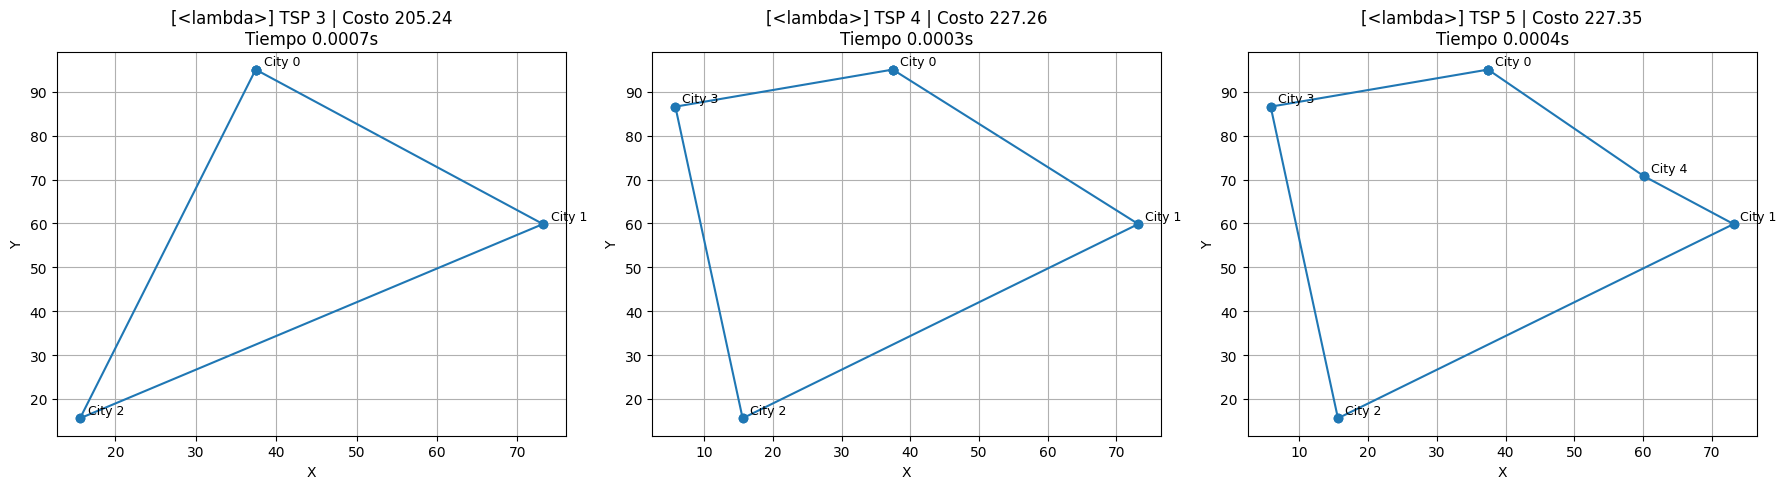

[4/13] ciudades=6 | tiempo=0.0006s | costo=241.07
[5/13] ciudades=7 | tiempo=0.0008s | costo=276.22
[6/13] ciudades=8 | tiempo=0.0021s | costo=277.23


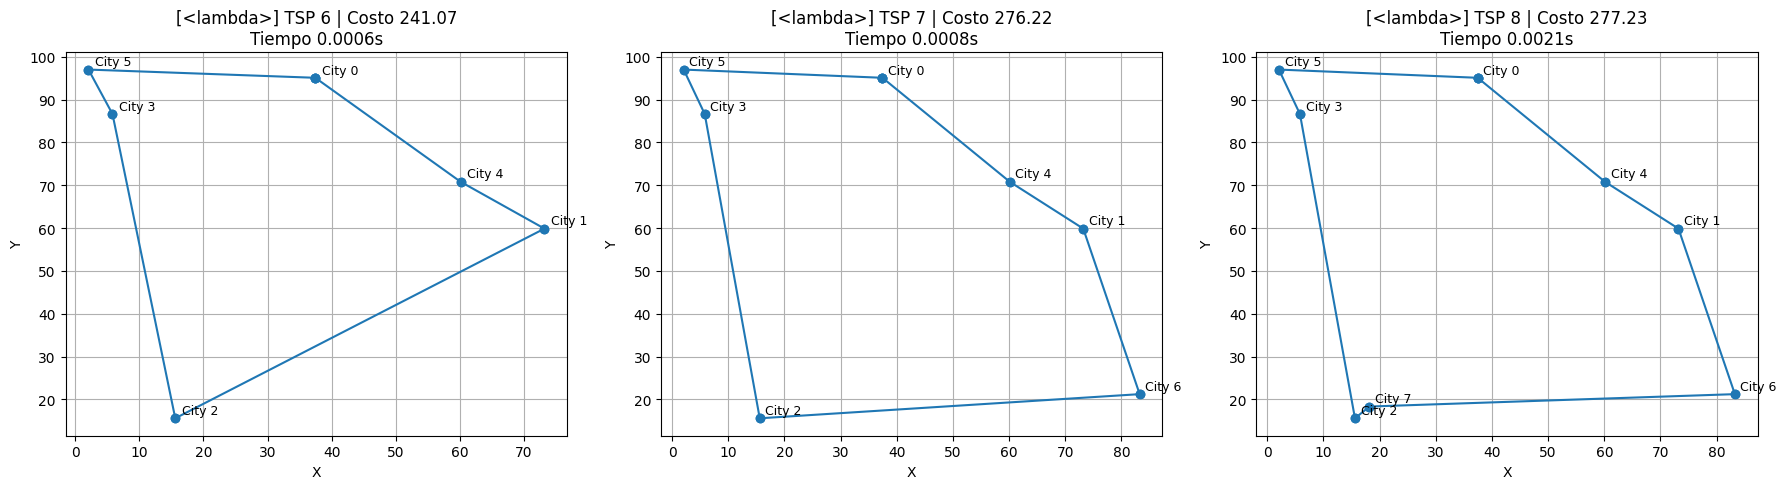

[7/13] ciudades=9 | tiempo=0.0190s | costo=286.65
[8/13] ciudades=10 | tiempo=0.0142s | costo=290.31
[9/13] ciudades=11 | tiempo=0.0295s | costo=296.25


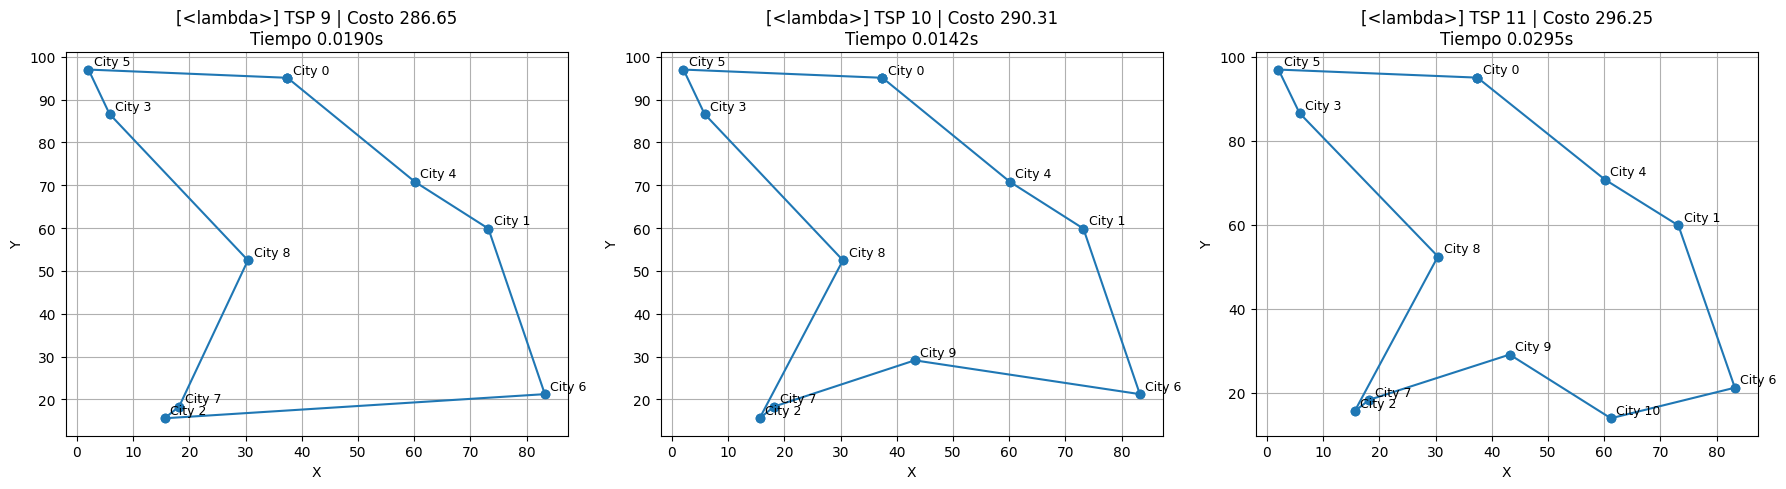

[10/13] ciudades=12 | tiempo=0.0886s | costo=297.25
[11/13] ciudades=13 | tiempo=0.1879s | costo=298.93
[12/13] ciudades=14 | tiempo=0.4714s | costo=305.29


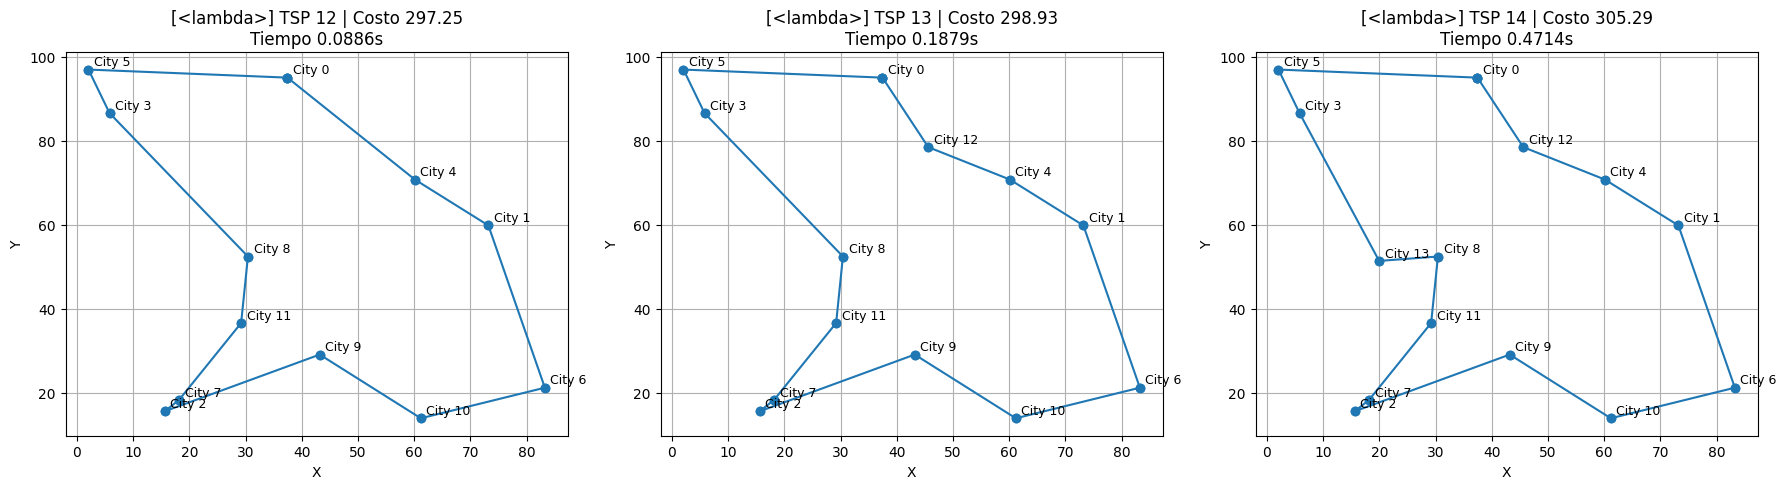

[13/13] ciudades=15 | tiempo=2.3504s | costo=320.53


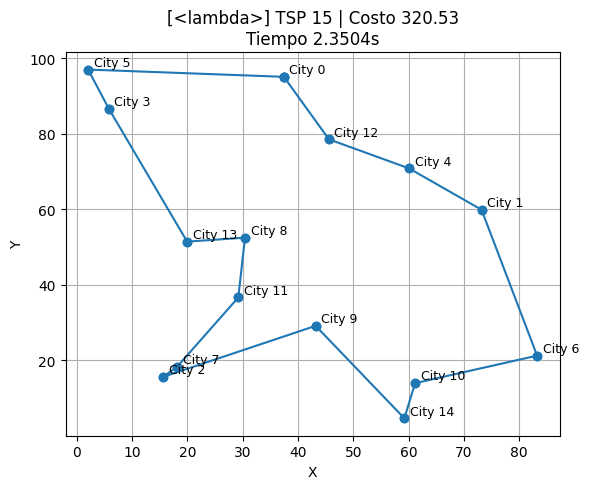


n  | ruta                                                | largo  | tiempo(s)
---+-----------------------------------------------------+--------+----------
3  | 0->2->1->0                                          | 205.24 | 0.0007   
4  | 0->1->2->3->0                                       | 227.26 | 0.0003   
5  | 0->3->2->1->4->0                                    | 227.35 | 0.0004   
6  | 0->4->1->2->3->5->0                                 | 241.07 | 0.0006   
7  | 0->4->1->6->2->3->5->0                              | 276.22 | 0.0008   
8  | 0->4->1->6->7->2->3->5->0                           | 277.23 | 0.0021   
9  | 0->4->1->6->2->7->8->3->5->0                        | 286.65 | 0.0190   
10 | 0->4->1->6->9->7->2->8->3->5->0                     | 290.31 | 0.0142   
11 | 0->4->1->6->10->9->7->2->8->3->5->0                 | 296.25 | 0.0295   
12 | 0->4->1->6->10->9->2->7->11->8->3->5->0             | 297.25 | 0.0886   
13 | 0->12->4->1->6->10->9->2->7->11->8->3->5->0         | 298.

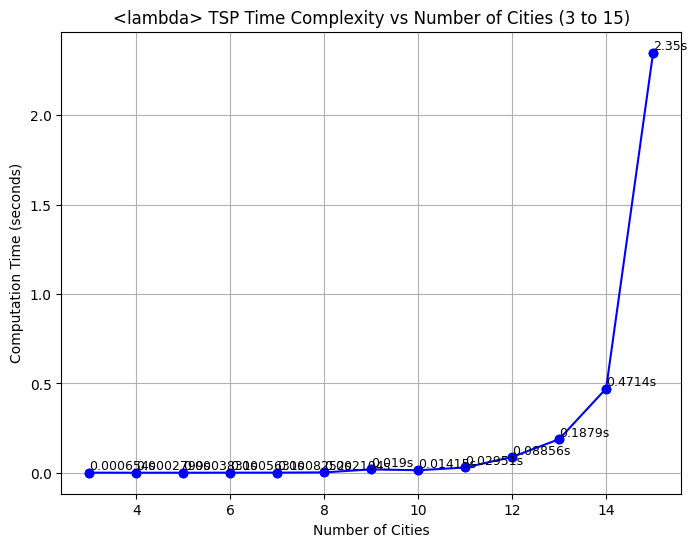

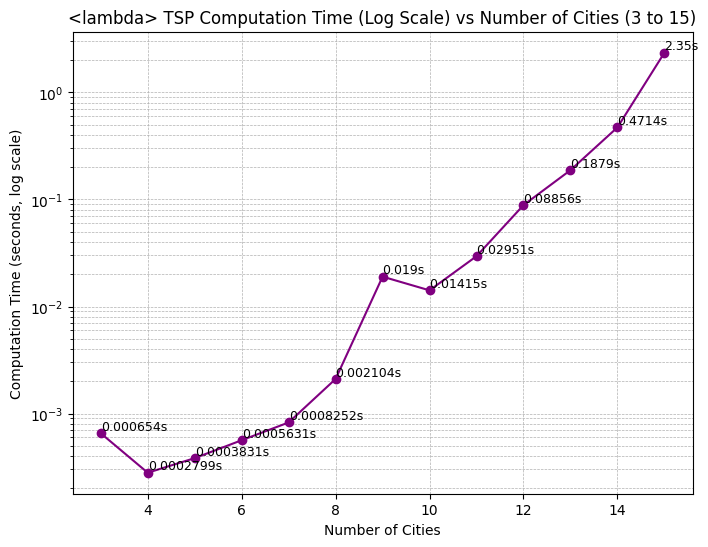

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] [0.0006539821624755859, 0.0002799034118652344, 0.00038313865661621094, 0.0005631446838378906, 0.0008251667022705078, 0.0021038055419921875, 0.01900029182434082, 0.014154195785522461, 0.02950763702392578, 0.08855724334716797, 0.18789219856262207, 0.4714322090148926, 2.3503730297088623] [205.235798196805, 227.25986949326284, 227.34551867849092, 241.06807549059886, 276.21833744551475, 277.2324195168246, 286.6472235549413, 290.30677377778755, 296.25323192212375, 297.2509182121361, 298.93200692682495, 305.2866704174466, 320.52566566960746]


In [24]:
np.random.seed(42)

algorithm=solve_best_lb_cost
max_cities = 15 
city_counts, solve_times, best_costs = run_n_cities(algorithm, max_cities, show_plots=True)
print(city_counts, solve_times, best_costs)


### Comparativa de algoritmos

[1/13] ciudades=3 | tiempo=0.0003s | costo=205.24
[2/13] ciudades=4 | tiempo=0.0003s | costo=227.26
[3/13] ciudades=5 | tiempo=0.0003s | costo=227.35
[4/13] ciudades=6 | tiempo=0.0005s | costo=241.07
[5/13] ciudades=7 | tiempo=0.0015s | costo=276.22
[6/13] ciudades=8 | tiempo=0.0049s | costo=277.23
[7/13] ciudades=9 | tiempo=0.0102s | costo=286.65
[8/13] ciudades=10 | tiempo=0.0307s | costo=290.31
[9/13] ciudades=11 | tiempo=0.0703s | costo=296.25
[10/13] ciudades=12 | tiempo=0.1232s | costo=297.25
[11/13] ciudades=13 | tiempo=0.4547s | costo=298.93
[12/13] ciudades=14 | tiempo=0.6953s | costo=305.29
[13/13] ciudades=15 | tiempo=1.4063s | costo=320.53

n  | ruta                                             | largo  | tiempo(s)
---+--------------------------------------------------+--------+----------
3  | 1->2->0                                          | 205.24 | 0.0003   
4  | 3->2->1->0                                       | 227.26 | 0.0003   
5  | 4->1->2->3->0                     

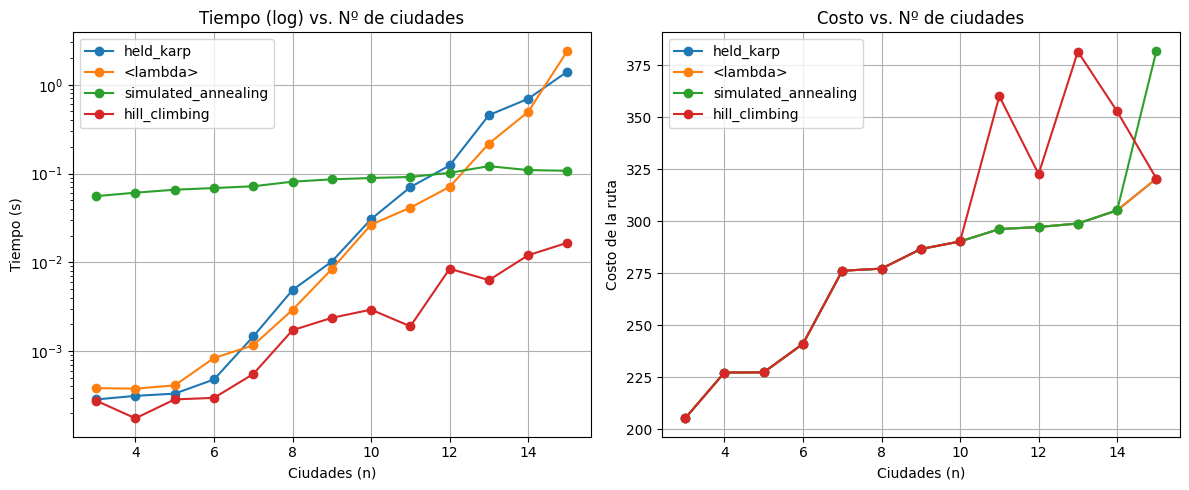

In [25]:
algs = [held_karp,solve_best_lb_cost, simulated_annealing, hill_climbing]
series = plot_algorithms_times_costs(algs, max_cities=15) ##A efectos practico se recomienda bajar a n=20 ya que esto podria demorar mucho 